In [1]:
import sys
import time
from datetime import datetime
import pandas as pd
import geopandas as gpd
import numpy as np
import glob as glb
from shapely.geometry import box
from shapely.geometry import Polygon
from shapely.geometry import Point
import shapely.wkt
# from datetimerange import DateTimeRange
import datetime as dt
import astropy.units as u
from astropy.coordinates import SkyCoord
from sunpy.coordinates import frames
import numpy as np

In [51]:
from scipy.spatial import distance as dist
from scipy.spatial.distance import cdist
import os

In [3]:
import math
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [4]:
from datetime import timedelta
import matplotlib.pyplot as plt
%matplotlib inline

In [85]:
def read_pil(file):
    
    #read single pil file and extract specific column
    
    harp_num = file.split('/')[-2]#obtain harp number
    
    print(harp_num)
    
    pil_df = pd.read_csv('{}'.format(file))
    pil_df = pil_df.rename(columns={'Unnamed: 0': 'Time_stamp'})
    pil_df['Time_stamp'] = pd.to_datetime(pil_df['Time_stamp'])
    pil_df['HARP_number'] = harp_num
    
    n_pil_df = pil_df[pil_df['detection_flag'] !='no pil SPE'].copy()
    
    if len(n_pil_df)>0:
        
        n_df = n_pil_df[['HARP_number','Time_stamp','sum_PIL_length','sum_RoPI_Area','sum_mag_field_strength','fra_dim']].copy()
        
        n_df.fillna(0,inplace=True)
        
        return n_df
    

    

In [136]:
def pil_2h_avg(df):
    
    #use 2 hour average pil meta data
    
    harp_num = df['HARP_number'].unique()
    
    df_2h = df.resample('2h',on='Time_stamp').mean().reset_index().copy()
    
    df_2h['HARP_number'] = int(df['HARP_number'].unique()[0])
    
    df_2h.interpolate(method='linear', limit_direction='forward', axis=0,inplace=True)
    
    if sum(df_2h['sum_PIL_length']!=0) and len(df_2h)>=2:
    
        return df_2h[['HARP_number','Time_stamp','sum_PIL_length','sum_RoPI_Area','sum_mag_field_strength','fra_dim']]

In [163]:
def load_pil_file(folder_path):
    
    #read PIL evolution dataset from each HARP_pil.csv folder and create 2 hour average meta data.
    
    data_harp ={}
    
    dirs = [name for name in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, name))]
    
    for filename in dirs:
        
#         print(filename)
        
        f_path = os.path.join(folder_path, filename,'{}_pil.csv'.format(filename))
        
        df1 = read_pil(f_path)
        
#         print(f_path)
        if df1 is not None:
        
            df_2h = pil_2h_avg(df1)
            
            if df_2h is not None:
                    
        
                df_2h.sort_values(by=['Time_stamp'],inplace=True)    
                data_harp[int(filename)]=df_2h
        

        
    
    return data_harp

#### Transform trajectory to trajectory segments and feature extraction

In [159]:


def trj_seg_spatial(trj,trj_id):
    
    
    size_change = [j - i for i,j in zip(trj['sum_PIL_length'][:-1],trj['sum_PIL_length'][1:])] # thinned PIL length
    
#     region_change = [j - i for i,j in zip(trj['Total Area Strength'][:-1],trj['Total Area Strength'][1:])] #RoPI region 
    
    flux_change = [j - i for i,j in zip(trj['sum_mag_field_strength'][:-1],trj['sum_mag_field_strength'][1:])] #Magnetic field Strength enclosed PIL
    
    fractal_change = [j - i for i,j in zip(trj['fra_dim'][:-1],trj['fra_dim'][1:])] #RoPI/AR change rate
    
#     rpi_convex_change = [j - i for i,j in zip(trj['RoPI/Covex'][:-1],trj['RoPI/Covex'][1:])] #RoPI/Covex change rate
    
    idx_lst = [[i,j] for i,j in zip(trj.index.values[:-1],trj.index.values[1:])] #index of corresponding id of trj
    
#     v_angle = [math.degrees(math.atan2(lat,lon)) for lon,lat in zip(v_lon_displace,v_lat_displace)]#vector angle
    
#     v_position = [[i.x,i.y,j.x,j.y] for i,j in zip(point_list[:-1],point_list[1:])]
    
    
    
    trj_seg = {'PIL_size_diff': size_change,'Flux_diff':flux_change,'frac_diff':fractal_change}
    
    trj_seg_df = pd.DataFrame(trj_seg,columns = list(trj_seg.keys()))
    
    trj_seg_df['HARP_num'] = trj_id
    
    trj_seg_df['harp_trj_id'] = idx_lst
    
    
    return trj_seg_df


In [173]:
def generate_trj_data(data_dict):
    
    data_trj = []
    
    for h_number,df in data_dict.items():
        
        
        pil_trj_seg = trj_seg_spatial(df,h_number)
        
        data_trj.append(pil_trj_seg)
        
        
    trj_dataset = pd.concat(data_trj)
        
    return trj_dataset
        
    
    

#### AB score calculation

In [209]:
def abScore(data,label,c_center):
    
    ab_list = []
    
    weights_lst = [len(label[label == lab]) / len(label) for i,lab in enumerate(list(set(label)))]
    
    
    for i,d in enumerate(data):
        
        ab_score = 0
        

        for j, w in enumerate(weights_lst):
            
            ab_score += w * dist.euclidean(d,c_center[j])
            
        
        ab_list.append(ab_score)
        
    
    return ab_list

### Clean and get raw trajectory spatio-temporal datasets

In [187]:
folder_path = '/PIL_raw_trj_data_01_2000/'

In [188]:
data_harp = load_pil_file(folder_path)

1069
797
909
135
307
1432
1600
338
556
764
1638
59
790
931
92
66
336
938
104
560
752
1890
1093
799
50
1863
68
755
1299
567
331
57
1252
1060
1404
1636
900
1094
1206
1662
1450
1696
168
1837
533
701
739
1691
953
1457
1201
150
362
1830
998
1495
32
1237
1005
1461
991
1653
1698
166
354
1806
1466
398
35
1492
195
161
1298
566
754
330
1608
592
1862
901
559
1253
1637
1405
595
105
753
561
51
1066
798
1092
1639
58
765
557
133
301
67
1606
306
550
762
1854
796
1291
937
1601
1433
1493
399
997
160
504
1800
990
1460
964
158
1209
1807
731
355
1699
1456
738
1690
1469
397
535
1697
1035
1663
700
532
156
364
390
1836
1238
1944
1178
686
672
440
1523
1711
1381
229
827
675
211
1943
681
1988
1386
1372
643
1981
1149
218
1176
688
1388
220
1343
1171
1727
1773
1541
1787
845
1926
610
274
842
1546
1774
1122
273
617
425
889
287
874
1326
1570
880
1742
621
1789
245
1319
887
1113
1321
619
1548
414
626
1389
1987
221
483
1184
1170
1342
1514
1148
1974
226
642
470
1721
1345
1177
689
1183
219
817
1942
680
674
1387
1989
217
81

In [189]:
#Concat data to obtain the raw data of 2 hour average
data_harp_list = [data_harp[df] for df in data_harp]
raw_data = pd.concat(data_harp_list)

In [192]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40407 entries, 0 to 9
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   HARP_number             40407 non-null  int64         
 1   Time_stamp              40407 non-null  datetime64[ns]
 2   sum_PIL_length          40407 non-null  float64       
 3   sum_RoPI_Area           40407 non-null  float64       
 4   sum_mag_field_strength  40407 non-null  float64       
 5   fra_dim                 40407 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 2.2 MB


In [255]:
raw_data['HARP_number'].value_counts()

1908    115
1345    113
321     113
1715    113
538     112
       ... 
899       5
1329      4
734       3
701       2
1152      2
Name: HARP_number, Length: 525, dtype: int64

In [194]:
len(raw_data['HARP_number'].unique())

525

In [358]:
raw_data['Time_stamp'].max()

Timestamp('2012-09-10 04:00:00')

In [360]:
raw_data.to_csv('2h_average_PIL_evolution.csv')

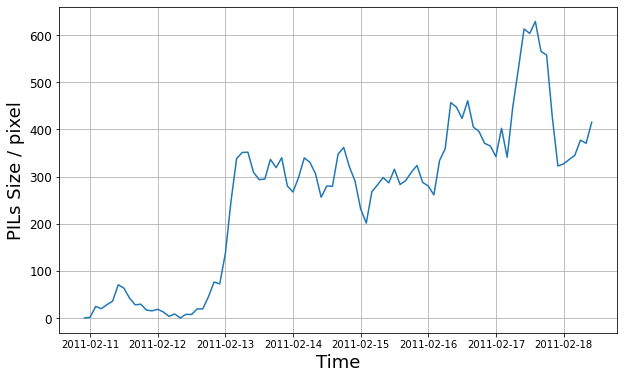

In [253]:
plt.figure(figsize=(10,6))
ax = sns.lineplot(data=raw_data[raw_data['HARP_number']==377], x=raw_data[raw_data['HARP_number']==377]['Time_stamp'],y="sum_PIL_length")

plt.grid()
# plt.xticks(np.arange(pil_377_meta.index.min(),pil_377_meta.index.max(),datetime.timedelta(hours=6,minutes=0)) ,rotation=90)
plt.yticks(fontsize = 12)
# ax.set_xticks(x_ticks_label)
# date_form = mdates.DateFormatter("%m-%d %H:%M")
# ax.xaxis.set_major_formatter(date_form)
# # plt.title('Average Weekly Sales - Per Year', fontsize=18)
plt.ylabel('PILs Size / pixel', fontsize=18)
plt.xlabel('Time', fontsize=18)
# plt.title('Average Weekly Equal_TRPS_CM_TY - Per Year', fontsize=18)
# plt.savefig('/Users/xumin/PIL_paper_377/eda_pil_size.pdf',dpi = 300,bbox_inches='tight')
plt.show()

### Generate Trajectory segments datasets

#### Using 2 hour average meta data of PIL to generate trajectory segments

In [199]:

pil_trj = generate_trj_data(data_harp)

In [200]:
pil_trj

PIL_size_diff  Flux_diff  frac_diff  HARP_num harp_trj_id
0             2.4    1582.27   0.002698       909      [0, 1]
1            22.0    6006.76   0.069950       909      [1, 2]
2             0.7    6149.66   0.082176       909      [2, 3]
3            -9.6   -5552.51  -0.130371       909      [3, 4]
4           -35.5   -9584.77  -0.212810       909      [4, 5]
..            ...        ...        ...       ...         ...
4             5.1    1093.12   0.137966       986      [4, 5]
5             0.6    -156.71   0.041115       986      [5, 6]
6             5.9    1611.06   0.009647       986      [6, 7]
7            -2.1   -1151.78  -0.098676       986      [7, 8]
8             4.0     301.39   0.035077       986      [8, 9]

[39882 rows x 5 columns]

In [202]:
pil_trj.describe()

PIL_size_diff      Flux_diff     frac_diff      HARP_num
count   39882.000000   39882.000000  39882.000000  39882.000000
mean       -0.022396     -14.714331     -0.000113    969.384635
std        14.647449    8467.995978      0.083376    576.341918
min      -371.800000 -409174.160000     -0.613722      1.000000
25%        -0.500000    -111.237321     -0.002990    474.000000
50%         0.000000       0.000000      0.000000    913.000000
75%         0.133333      63.267500      0.001950   1465.000000
max       457.500000  367050.550000      0.721506   1999.000000

### Normalization

In [203]:
mms = MinMaxScaler()
mms.fit(pil_trj[['PIL_size_diff','Flux_diff','frac_diff']]) #,'RoPI'
test_data_transformed = mms.transform(pil_trj[['PIL_size_diff','Flux_diff','frac_diff']])#RoPI','RoPI_Covex'

In [204]:
Sum_of_squared_distances_minmax = []
sil_minmax = []
K = range(2,9)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(test_data_transformed)
    Sum_of_squared_distances_minmax.append(km.inertia_)
    

    labels = km.labels_
    sil_minmax.append(silhouette_score(test_data_transformed, labels, metric = 'euclidean'))

### Choose Optimal K

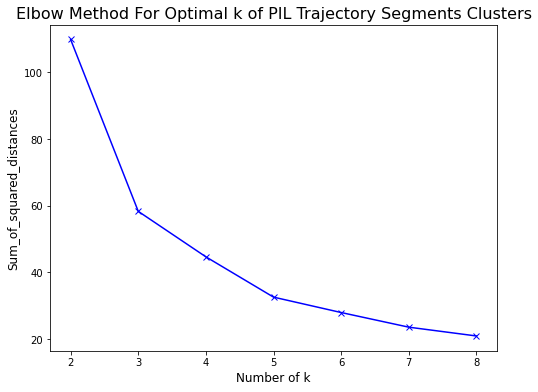

In [205]:
plt.figure(figsize = (8,6))
plt.plot(K, Sum_of_squared_distances_minmax, 'bx-')
plt.xlabel('Number of k',fontsize = 12)
plt.ylabel('Sum_of_squared_distances',fontsize = 12)
plt.title('Elbow Method For Optimal k of PIL Trajectory Segments Clusters',fontsize = 16)
# plt.savefig('Elbow for PIL.png',bbox_inches='tight')
plt.show()

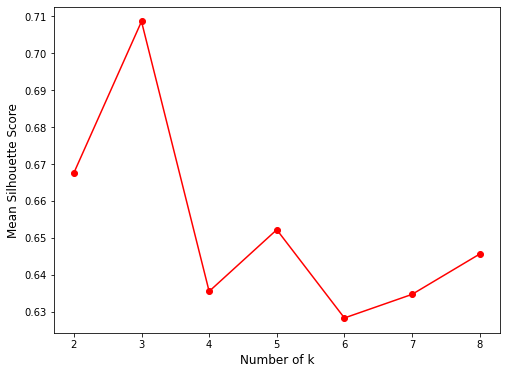

In [206]:
plt.figure(figsize = (8,6))
plt.plot(K, sil_minmax, 'ro-')
plt.xlabel('Number of k',fontsize = 12)
plt.ylabel('Mean Silhouette Score',fontsize = 12)
# plt.title('Silhouette_score For Optimal k')
# plt.savefig('Mean Silhouette Coefficient for NOAA.png',bbox_inches='tight')
plt.show()

###  Cluster =3

In [207]:
kk_test_3 = KMeans(n_clusters=3).fit(test_data_transformed)

### Calculate AB Score

In [210]:
ab_Score_3 = abScore(test_data_transformed,kk_test_3.labels_,kk_test_3.cluster_centers_)

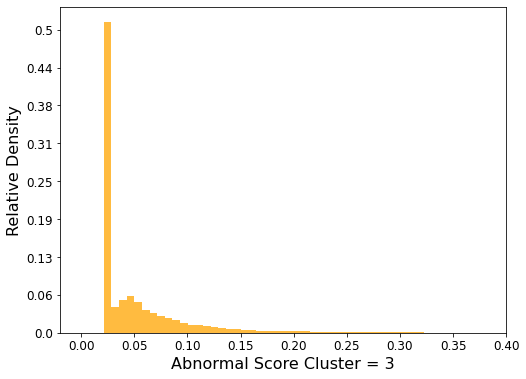

In [355]:
hist, bin_edges = np.histogram(ab_Score_3)
fig, ax = plt.subplots(1,1,figsize=(8, 6))
ax.hist(ab_Score_3,density=False,facecolor='orange',alpha=0.75,bins=100)
ticks =  ax.get_yticks()
ax.tick_params(labelsize=12)
# set labels to absolute values and with integer representation
ax.set_yticklabels([round(tick/len(ab_Score_3),2)for tick in ticks])
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 0.05))
ax.set_xlim((-0.02,0.4))
ax.set_ylabel('Relative Density',fontsize=16)
ax.set_xlabel('Abnormal Score Cluster = 3',fontsize=16)
# sns.distplot(nm_Score, hist=False, bins=19, kde=True,
#             color = 'darkblue', 
#              hist_kws={'edgecolor':'black'},
#              )
plt.savefig('AB_Score_bar_plot_PIL_01_2000_update.pdf',dpi=600,bbox_inches='tight')
plt.show()

In [212]:
pil_trj['labels_cluster_3']=kk_test_3.labels_

In [213]:
pil_trj['ab_Score_3']= ab_Score_3

In [305]:
pil_trj[pil_trj['ab_Score_3'] <0.175].describe()

PIL_size_diff      Flux_diff     frac_diff      HARP_num  \
count   38450.000000   38450.000000  38450.000000  38450.000000   
mean       -0.067171     -30.806157     -0.000205    970.136905   
std        13.217556    7403.112563      0.057564    576.447658   
min      -130.600000 -125028.410000     -0.232944      1.000000   
25%        -0.100000     -11.450000      0.000000    480.000000   
50%         0.000000       0.000000      0.000000    913.000000   
75%         0.000000       0.000000      0.000000   1465.000000   
max       119.700000  111020.790000      0.232826   1999.000000   

       labels_cluster_3    ab_Score_3  
count      38450.000000  38450.000000  
mean           1.004473      0.044163  
std            0.354989      0.032975  
min            0.000000      0.021372  
25%            1.000000      0.021421  
50%            1.000000      0.021421  
75%            1.000000      0.057254  
max            2.000000      0.174950

In [306]:
pil_trj[pil_trj['ab_Score_3'] >=0.175].describe()

PIL_size_diff      Flux_diff    frac_diff     HARP_num  \
count    1432.000000    1432.000000  1432.000000  1432.000000   
mean        1.179820     417.360188     0.002383   949.185754   
std        35.829453   22927.421894     0.323566   573.326664   
min      -371.800000 -409174.160000    -0.613722     1.000000   
25%       -14.800000   -4280.255000    -0.296726   436.000000   
50%         5.800000     549.741667     0.054074   903.000000   
75%        15.500000    4641.217500     0.291247  1461.000000   
max       457.500000  367050.550000     0.721506  1998.000000   

       labels_cluster_3   ab_Score_3  
count       1432.000000  1432.000000  
mean           0.987430     0.240413  
std            0.994666     0.060992  
min            0.000000     0.175037  
25%            0.000000     0.195395  
50%            0.000000     0.223440  
75%            2.000000     0.267849  
max            2.000000     0.739580

In [307]:
pil_trj[pil_trj['labels_cluster_3'] ==0].describe()

PIL_size_diff      Flux_diff    frac_diff     HARP_num  \
count    3054.000000    3054.000000  3054.000000  3054.000000   
mean       14.973580    5468.100391     0.180799   966.969876   
std        19.901714   11479.571524     0.090583   574.189187   
min       -35.300000  -21766.683333     0.046480     1.000000   
25%         5.900000    1218.612500     0.112477   444.000000   
50%         9.900000    2708.180000     0.152031   926.000000   
75%        17.975000    6306.177500     0.219673  1465.000000   
max       457.500000  367050.550000     0.721506  1999.000000   

       labels_cluster_3   ab_Score_3  
count            3054.0  3054.000000  
mean                0.0     0.143485  
std                 0.0     0.065777  
min                 0.0     0.079189  
25%                 0.0     0.096211  
50%                 0.0     0.121941  
75%                 0.0     0.169885  
max                 0.0     0.739580

In [308]:
pil_trj[pil_trj['labels_cluster_3'] ==1].describe()

PIL_size_diff      Flux_diff     frac_diff      HARP_num  \
count   33620.000000   33620.000000  33620.000000  33620.000000   
mean       -0.016027     -22.802368      0.000296    969.383224   
std        12.229869    7472.241726      0.028236    576.791854   
min      -159.100000 -131035.080000     -0.095174      1.000000   
25%         0.000000       0.000000      0.000000    480.000000   
50%         0.000000       0.000000      0.000000    909.000000   
75%         0.000000       0.000000      0.000000   1465.000000   
max       134.600000  115021.600000      0.094088   1999.000000   

       labels_cluster_3    ab_Score_3  
count           33620.0  33620.000000  
mean                1.0      0.034354  
std                 0.0      0.019707  
min                 1.0      0.021372  
25%                 1.0      0.021421  
50%                 1.0      0.021421  
75%                 1.0      0.045375  
max                 1.0      0.228890

In [309]:
pil_trj[pil_trj['labels_cluster_3'] ==2].describe()

PIL_size_diff      Flux_diff    frac_diff     HARP_num  \
count    3208.000000    3208.000000  3208.000000  3208.000000   
mean      -14.365245   -5149.563566    -0.176617   971.698254   
std        17.409792   11222.845477     0.089129   573.833724   
min      -371.800000 -409174.160000    -0.613722     1.000000   
25%       -17.400000   -6127.350000    -0.216333   451.000000   
50%        -9.600000   -2582.775000    -0.146959   926.000000   
75%        -5.600000   -1166.712500    -0.110029  1465.000000   
max        40.100000   17837.440000    -0.064513  1999.000000   

       labels_cluster_3   ab_Score_3  
count            3208.0  3208.000000  
mean                2.0     0.140003  
std                 0.0     0.064131  
min                 2.0     0.077454  
25%                 2.0     0.094022  
50%                 2.0     0.117604  
75%                 2.0     0.164894  
max                 2.0     0.702399

In [359]:
pil_trj[pil_trj['ab_Score_3'] <0.175].describe()

PIL_size_diff      Flux_diff     frac_diff      HARP_num  \
count   38450.000000   38450.000000  38450.000000  38450.000000   
mean       -0.067171     -30.806157     -0.000205    970.136905   
std        13.217556    7403.112563      0.057564    576.447658   
min      -130.600000 -125028.410000     -0.232944      1.000000   
25%        -0.100000     -11.450000      0.000000    480.000000   
50%         0.000000       0.000000      0.000000    913.000000   
75%         0.000000       0.000000      0.000000   1465.000000   
max       119.700000  111020.790000      0.232826   1999.000000   

       labels_cluster_3    ab_Score_3    ab_Score_2    ab_Score_5  \
count      38450.000000  38450.000000  38450.000000  38450.000000   
mean           1.004473      0.044163      0.042825      0.048470   
std            0.354989      0.032975      0.031409      0.031000   
min            0.000000      0.021372      0.013467      0.027600   
25%            1.000000      0.021421      0.023859      0.027952   
50%            1.000000      0.021421      0.023859      0.027952   
75%            1.000000      0.057254      0.052111      0.058630   
max            2.000000      0.174950      0.174926      0.176776   

        ab_Score_10   ab_Score_15   ab_Score_20   ab_Score_25   ab_Score_30  
count  38450.000000  38450.000000  38450.000000  38450.000000  38450.000000  
mean       0.051150      0.051696      0.051812      0.052118      0.052277  
std        0.030000      0.029875      0.029836      0.029745      0.029701  
min        0.031353      0.032379      0.032584      0.032985      0.033180  
25%        0.031739      0.032412      0.032584      0.032985      0.033191  
50%        0.031739      0.032412      0.032584      0.032985      0.033191  
75%        0.059593      0.060189      0.060279      0.060467      0.060566  
max        0.177366      0.177789      0.177757      0.177882      0.177870

In [310]:
#Minority 1
pil_trj[(pil_trj['ab_Score_3'] >=0.175) & (pil_trj['labels_cluster_3']== 0)].describe()

PIL_size_diff      Flux_diff   frac_diff     HARP_num  \
count     717.000000     717.000000  717.000000   717.000000   
mean       21.810958    8121.208842    0.313805   936.553696   
std        29.580450   19088.925037    0.083193   570.410955   
min        -8.100000   -4540.140000    0.046480     1.000000   
25%        11.500000    2842.860000    0.256915   414.000000   
50%        15.400000    4550.320000    0.291181   902.000000   
75%        22.300000    8061.150000    0.349990  1461.000000   
max       457.500000  367050.550000    0.721506  1998.000000   

       labels_cluster_3  ab_Score_3  
count             717.0  717.000000  
mean                0.0    0.240564  
std                 0.0    0.063532  
min                 0.0    0.175037  
25%                 0.0    0.195019  
50%                 0.0    0.221820  
75%                 0.0    0.265570  
max                 0.0    0.739580

In [311]:
#Minority 2
pil_trj[(pil_trj['ab_Score_3'] >=0.175) & (pil_trj['labels_cluster_3']==2)].describe()

PIL_size_diff      Flux_diff   frac_diff     HARP_num  \
count     699.000000     699.000000  699.000000   699.000000   
mean      -19.431767   -7282.056446   -0.316841   952.459227   
std        23.142740   19749.846452    0.076376   573.991608   
min      -371.800000 -409174.160000   -0.613722     1.000000   
25%       -20.250000   -7175.028571   -0.360394   438.000000   
50%       -14.800000   -4246.700000   -0.298564   900.000000   
75%       -11.012500   -2531.220000   -0.260016  1455.500000   
max        -3.600000    1331.710000   -0.074693  1998.000000   

       labels_cluster_3  ab_Score_3  
count             699.0  699.000000  
mean                2.0    0.241286  
std                 0.0    0.058586  
min                 2.0    0.175055  
25%                 2.0    0.197835  
50%                 2.0    0.225412  
75%                 2.0    0.271093  
max                 2.0    0.702399

In [312]:
#Minority 3
pil_trj[(pil_trj['ab_Score_3'] >=0.175) & (pil_trj['labels_cluster_3']== 1)].describe()

PIL_size_diff      Flux_diff  frac_diff     HARP_num  labels_cluster_3  \
count      16.000000      16.000000  16.000000    16.000000              16.0   
mean      -22.884375   -8443.093437  -0.007119  1372.250000               1.0   
std       122.553637   94453.338132   0.038327   545.132339               0.0   
min      -159.100000 -131035.080000  -0.051498   393.000000               1.0   
25%      -125.525000  -77451.242500  -0.040918  1309.750000               1.0   
50%       -95.150000  -59083.845000  -0.018857  1449.000000               1.0   
75%        96.425000   92319.180000   0.029900  1807.000000               1.0   
max       134.600000  115021.600000   0.052641  1834.000000               1.0   

       ab_Score_3  
count   16.000000  
mean     0.195526  
std      0.018015  
min      0.175375  
25%      0.179370  
50%      0.190242  
75%      0.205211  
max      0.228890

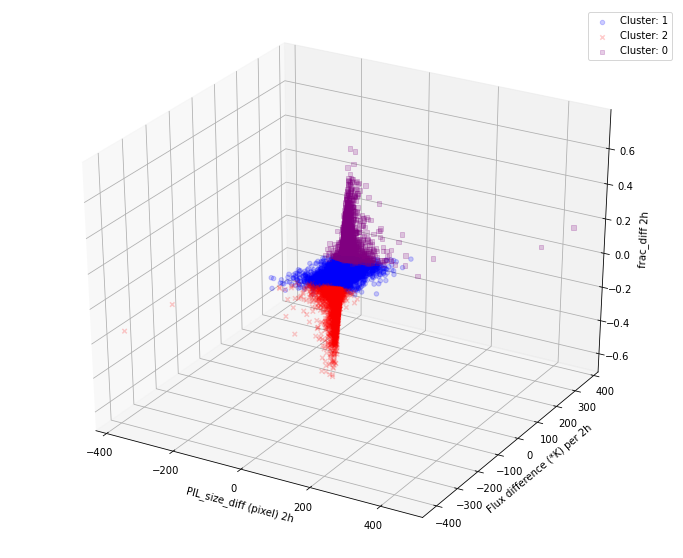

In [313]:
labels = pil_trj.labels_cluster_3.unique()
#Distribution Plot of X with two seperatable class
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
    
colors = ["blue","red","purple"]
markers = ('o', 'x', 's')

for i, yi in enumerate(labels):
        cluster_data = pil_trj[pil_trj.labels_cluster_3 == yi]

        ax.scatter(cluster_data['PIL_size_diff'],cluster_data['Flux_diff']/1000,
                   cluster_data['frac_diff'],
                        color=colors[i], marker=markers[i], alpha = 0.2,label='Cluster: '+ '{}'.format(yi))
        
ax.legend()
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_zscale('log')

ax.set_xlabel('PIL_size_diff (pixel) 2h')
ax.set_ylabel('Flux difference (*K) per 2h')

ax.set_zlabel('frac_diff 2h')


plt.show()

### Create AB label

In [290]:
pil_trj['Ab_Label_0.175'] = pil_trj.apply(lambda x: 'Ab_Score < 0.175' if x.ab_Score_3 < 0.175 else 'Ab_Score >= 0.175 Cluster '+'{}'.format(x.labels_cluster_3),axis=1)


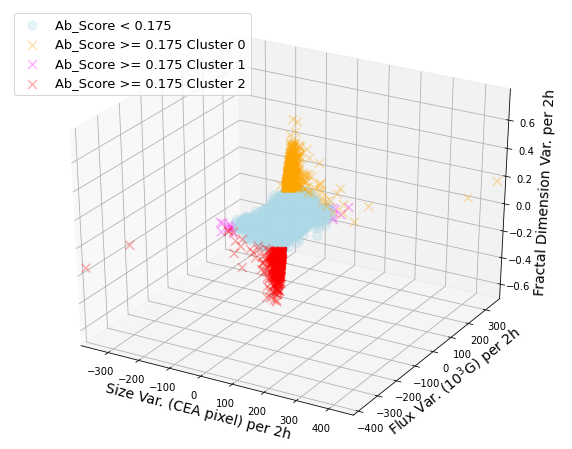

In [322]:
labels_AB_3 = ['Ab_Score < 0.175','Ab_Score >= 0.175 Cluster 0','Ab_Score >= 0.175 Cluster 1','Ab_Score >= 0.175 Cluster 2']

#Distribution Plot of X with two seperatable class
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
    
colors = ["lightblue","orange","fuchsia","red"]
markers = ('o', 'x', 'x',"x")

for i, yi in enumerate(labels_AB_3):
        cluster_data = pil_trj[pil_trj['Ab_Label_0.175'] == yi]

        ax.scatter(cluster_data['PIL_size_diff'],cluster_data['Flux_diff']/1000,
                   cluster_data['frac_diff'],
                        color=colors[i], marker=markers[i], alpha = 0.3,label='{}'.format(yi),s=80)
        
ax.legend(fontsize =13,loc='upper left')
# ax.set_xlim(-400,300)
# ax.set_zlim(-5,1)
# ax.set_ylim(-20,120)
ax.margins(x=-0.47, y= -0.47)
ax.set_xlabel('Size Var. (CEA pixel) per 2h',fontsize=14)
ax.set_ylabel(r'Flux Var. ($10^3$G) per 2h',fontsize=14)

ax.set_zlabel(r"Fractal Dimension Var. per 2h",fontsize=14)

# plt.title("Top 1% AB score")

plt.savefig('PIL_01_2000_AB_score.pdf',dpi=600,bbox_inches='tight')
plt.show()

### Number of outliers vs. K cluster analysis

In [323]:
kk_test_2 = KMeans(n_clusters=2).fit(test_data_transformed)
ab_Score_2 = abScore(test_data_transformed,kk_test_2.labels_,kk_test_2.cluster_centers_)

In [324]:
kk_test_5 = KMeans(n_clusters=5).fit(test_data_transformed)
ab_Score_5 = abScore(test_data_transformed,kk_test_5.labels_,kk_test_5.cluster_centers_)

In [325]:
kk_test_10 = KMeans(n_clusters=10).fit(test_data_transformed)
ab_Score_10 = abScore(test_data_transformed,kk_test_10.labels_,kk_test_10.cluster_centers_)

In [326]:
kk_test_15 = KMeans(n_clusters=15).fit(test_data_transformed)
ab_Score_15 = abScore(test_data_transformed,kk_test_15.labels_,kk_test_15.cluster_centers_)

In [327]:
kk_test_20 = KMeans(n_clusters=20).fit(test_data_transformed)
ab_Score_20 = abScore(test_data_transformed,kk_test_20.labels_,kk_test_20.cluster_centers_)

In [328]:
kk_test_25 = KMeans(n_clusters=25).fit(test_data_transformed)
ab_Score_25 = abScore(test_data_transformed,kk_test_25.labels_,kk_test_25.cluster_centers_)

In [329]:
kk_test_30 = KMeans(n_clusters=30).fit(test_data_transformed)
ab_Score_30 = abScore(test_data_transformed,kk_test_30.labels_,kk_test_30.cluster_centers_)

In [330]:
pil_trj['ab_Score_2']= ab_Score_2
pil_trj['ab_Score_5']= ab_Score_5
pil_trj['ab_Score_10']= ab_Score_10
pil_trj['ab_Score_15']= ab_Score_15
pil_trj['ab_Score_20']= ab_Score_20
pil_trj['ab_Score_25']= ab_Score_25
pil_trj['ab_Score_30']= ab_Score_30

In [333]:
pil_trj[pil_trj['ab_Score_3'] >=0.175].describe()

PIL_size_diff      Flux_diff    frac_diff     HARP_num  \
count    1432.000000    1432.000000  1432.000000  1432.000000   
mean        1.179820     417.360188     0.002383   949.185754   
std        35.829453   22927.421894     0.323566   573.326664   
min      -371.800000 -409174.160000    -0.613722     1.000000   
25%       -14.800000   -4280.255000    -0.296726   436.000000   
50%         5.800000     549.741667     0.054074   903.000000   
75%        15.500000    4641.217500     0.291247  1461.000000   
max       457.500000  367050.550000     0.721506  1998.000000   

       labels_cluster_3   ab_Score_3   ab_Score_2   ab_Score_5  ab_Score_10  \
count       1432.000000  1432.000000  1432.000000  1432.000000  1432.000000   
mean           0.987430     0.240413     0.240317     0.240887     0.241685   
std            0.994666     0.060992     0.061034     0.060646     0.060373   
min            0.000000     0.175037     0.171585     0.176250     0.176857   
25%            0.000000     0.195395     0.195305     0.196201     0.197301   
50%            0.000000     0.223440     0.223131     0.223491     0.224623   
75%            2.000000     0.267849     0.267850     0.267923     0.268464   
max            2.000000     0.739580     0.738752     0.739950     0.740121   

       ab_Score_15  ab_Score_20  ab_Score_25  ab_Score_30  
count  1432.000000  1432.000000  1432.000000  1432.000000  
mean      0.241834     0.241902     0.241953     0.241994  
std       0.060377     0.060363     0.060350     0.060346  
min       0.177006     0.177090     0.177176     0.177203  
25%       0.197424     0.197480     0.197552     0.197591  
50%       0.224786     0.224850     0.224869     0.224969  
75%       0.268739     0.268691     0.268764     0.268758  
max       0.740175     0.740187     0.740213     0.740215

In [334]:
pil_trj[pil_trj['ab_Score_2'] >=0.175].describe()

PIL_size_diff      Flux_diff    frac_diff     HARP_num  \
count    1423.000000    1423.000000  1423.000000  1423.000000   
mean        0.907485     224.290397     0.002046   948.416725   
std        35.173597   22527.698726     0.324398   573.404734   
min      -371.800000 -409174.160000    -0.613722     1.000000   
25%       -14.800000   -4284.020000    -0.297120   436.000000   
50%         5.011111     312.660000     0.055507   903.000000   
75%        15.500000    4570.850000     0.291763  1461.000000   
max       457.500000  367050.550000     0.721506  1998.000000   

       labels_cluster_3   ab_Score_3   ab_Score_2   ab_Score_5  ab_Score_10  \
count       1423.000000  1423.000000  1423.000000  1423.000000  1423.000000   
mean           0.989459     0.240818     0.240737     0.241288     0.242087   
std            0.996069     0.060971     0.060997     0.060627     0.060351   
min            0.000000     0.175055     0.175004     0.177039     0.177632   
25%            0.000000     0.195876     0.195777     0.196708     0.197828   
50%            0.000000     0.223980     0.223868     0.224141     0.225329   
75%            2.000000     0.268459     0.268410     0.268490     0.268772   
max            2.000000     0.739580     0.738752     0.739950     0.740121   

       ab_Score_15  ab_Score_20  ab_Score_25  ab_Score_30  
count  1423.000000  1423.000000  1423.000000  1423.000000  
mean      0.242236     0.242304     0.242354     0.242396  
std       0.060355     0.060341     0.060329     0.060324  
min       0.177826     0.177834     0.177826     0.177955  
25%       0.197905     0.197974     0.198045     0.198081  
50%       0.225366     0.225488     0.225572     0.225558  
75%       0.269258     0.269320     0.269307     0.269392  
max       0.740175     0.740187     0.740213     0.740215

In [335]:
pil_trj[pil_trj['ab_Score_5'] >=0.175].describe()

PIL_size_diff      Flux_diff    frac_diff     HARP_num  \
count    1466.000000    1466.000000  1466.000000  1466.000000   
mean        1.108818     408.085750     0.001369   948.417462   
std        35.525286   22693.476635     0.321705   572.323178   
min      -371.800000 -409174.160000    -0.613722     1.000000   
25%       -14.708333   -4234.647500    -0.295520   430.750000   
50%         4.905556     190.063889     0.044044   903.000000   
75%        15.475000    4575.050000     0.288748  1461.000000   
max       457.500000  367050.550000     0.721506  1998.000000   

       labels_cluster_3   ab_Score_3   ab_Score_2   ab_Score_5  ab_Score_10  \
count       1466.000000  1466.000000  1466.000000  1466.000000  1466.000000   
mean           0.991814     0.238873     0.238776     0.239381     0.240174   
std            0.994834     0.061104     0.061146     0.060730     0.060470   
min            0.000000     0.173054     0.171585     0.175012     0.175418   
25%            0.000000     0.194125     0.193876     0.194984     0.196087   
50%            1.000000     0.222060     0.221947     0.222142     0.223393   
75%            2.000000     0.266417     0.266425     0.266487     0.266938   
max            2.000000     0.739580     0.738752     0.739950     0.740121   

       ab_Score_15  ab_Score_20  ab_Score_25  ab_Score_30  
count  1466.000000  1466.000000  1466.000000  1466.000000  
mean      0.240326     0.240392     0.240443     0.240485  
std       0.060470     0.060458     0.060446     0.060441  
min       0.175915     0.175895     0.175883     0.176027  
25%       0.196129     0.196236     0.196325     0.196360  
50%       0.223435     0.223532     0.223592     0.223638  
75%       0.267319     0.267259     0.267334     0.267329  
max       0.740175     0.740187     0.740213     0.740215

In [336]:
pil_trj[pil_trj['ab_Score_10'] >=0.175].describe()

PIL_size_diff      Flux_diff    frac_diff     HARP_num  \
count    1477.000000    1477.000000  1477.000000  1477.000000   
mean        1.047334     381.316099     0.000929   948.732566   
std        35.544785   22656.931078     0.321066   572.482626   
min      -371.800000 -409174.160000    -0.613722     1.000000   
25%       -14.750000   -4246.700000    -0.295296   429.000000   
50%         4.100000    -217.480000     0.034855   909.000000   
75%        15.400000    4562.450000     0.287463  1461.000000   
max       457.500000  367050.550000     0.721506  1998.000000   

       labels_cluster_3   ab_Score_3   ab_Score_2   ab_Score_5  ab_Score_10  \
count       1477.000000  1477.000000  1477.000000  1477.000000  1477.000000   
mean           0.993907     0.238381     0.238283     0.238899     0.239690   
std            0.994887     0.061141     0.061184     0.060759     0.060502   
min            0.000000     0.172408     0.171254     0.174401     0.175098   
25%            0.000000     0.193616     0.193559     0.194614     0.195664   
50%            1.000000     0.221842     0.221794     0.221915     0.223118   
75%            2.000000     0.266056     0.266104     0.266127     0.266626   
max            2.000000     0.739580     0.738752     0.739950     0.740121   

       ab_Score_15  ab_Score_20  ab_Score_25  ab_Score_30  
count  1477.000000  1477.000000  1477.000000  1477.000000  
mean      0.239844     0.239909     0.239960     0.240003  
std       0.060501     0.060490     0.060478     0.060473  
min       0.175296     0.175269     0.175259     0.175413  
25%       0.195765     0.195861     0.195873     0.195956  
50%       0.223213     0.223341     0.223359     0.223438  
75%       0.266992     0.266909     0.267010     0.266978  
max       0.740175     0.740187     0.740213     0.740215

In [337]:
pil_trj[pil_trj['ab_Score_15'] >=0.175].describe()

PIL_size_diff      Flux_diff    frac_diff     HARP_num  \
count    1481.000000    1481.000000  1481.000000  1481.000000   
mean        1.027557     367.364745     0.000931   949.027009   
std        35.510157   22631.923760     0.320850   572.305902   
min      -371.800000 -409174.160000    -0.613722     1.000000   
25%       -14.800000   -4276.490000    -0.294657   429.000000   
50%         4.100000    -217.480000     0.034855   918.000000   
75%        15.400000    4558.380000     0.287362  1461.000000   
max       457.500000  367050.550000     0.721506  1998.000000   

       labels_cluster_3   ab_Score_3   ab_Score_2   ab_Score_5  ab_Score_10  \
count       1481.000000  1481.000000  1481.000000  1481.000000  1481.000000   
mean           0.993923     0.238202     0.238104     0.238725     0.239515   
std            0.994901     0.061155     0.061197     0.060769     0.060514   
min            0.000000     0.172115     0.171254     0.174268     0.174673   
25%            0.000000     0.193555     0.193299     0.194437     0.195517   
50%            1.000000     0.221604     0.221579     0.221806     0.223073   
75%            2.000000     0.265904     0.265946     0.265976     0.266624   
max            2.000000     0.739580     0.738752     0.739950     0.740121   

       ab_Score_15  ab_Score_20  ab_Score_25  ab_Score_30  
count  1481.000000  1481.000000  1481.000000  1481.000000  
mean      0.239669     0.239734     0.239785     0.239828  
std       0.060513     0.060501     0.060490     0.060484  
min       0.175039     0.175006     0.175012     0.175176  
25%       0.195644     0.195658     0.195800     0.195799  
50%       0.223038     0.223164     0.223261     0.223233  
75%       0.266835     0.266721     0.266829     0.266784  
max       0.740175     0.740187     0.740213     0.740215

In [338]:
pil_trj[pil_trj['ab_Score_20'] >=0.175].describe()

PIL_size_diff      Flux_diff    frac_diff     HARP_num  \
count    1481.000000    1481.000000  1481.000000  1481.000000   
mean        1.027557     367.364745     0.000931   949.027009   
std        35.510157   22631.923760     0.320850   572.305902   
min      -371.800000 -409174.160000    -0.613722     1.000000   
25%       -14.800000   -4276.490000    -0.294657   429.000000   
50%         4.100000    -217.480000     0.034855   918.000000   
75%        15.400000    4558.380000     0.287362  1461.000000   
max       457.500000  367050.550000     0.721506  1998.000000   

       labels_cluster_3   ab_Score_3   ab_Score_2   ab_Score_5  ab_Score_10  \
count       1481.000000  1481.000000  1481.000000  1481.000000  1481.000000   
mean           0.993923     0.238202     0.238104     0.238725     0.239515   
std            0.994901     0.061155     0.061197     0.060769     0.060514   
min            0.000000     0.172115     0.171254     0.174268     0.174673   
25%            0.000000     0.193555     0.193299     0.194437     0.195517   
50%            1.000000     0.221604     0.221579     0.221806     0.223073   
75%            2.000000     0.265904     0.265946     0.265976     0.266624   
max            2.000000     0.739580     0.738752     0.739950     0.740121   

       ab_Score_15  ab_Score_20  ab_Score_25  ab_Score_30  
count  1481.000000  1481.000000  1481.000000  1481.000000  
mean      0.239669     0.239734     0.239785     0.239828  
std       0.060513     0.060501     0.060490     0.060484  
min       0.175039     0.175006     0.175012     0.175176  
25%       0.195644     0.195658     0.195800     0.195799  
50%       0.223038     0.223164     0.223261     0.223233  
75%       0.266835     0.266721     0.266829     0.266784  
max       0.740175     0.740187     0.740213     0.740215

In [339]:
pil_trj[pil_trj['ab_Score_25'] >=0.175].describe()

PIL_size_diff      Flux_diff    frac_diff     HARP_num  \
count    1483.000000    1483.000000  1483.000000  1483.000000   
mean        1.057797     372.153384     0.001233   949.668240   
std        35.498633   22617.065144     0.320739   572.213692   
min      -371.800000 -409174.160000    -0.613722     1.000000   
25%       -14.775000   -4261.595000    -0.294654   432.500000   
50%         4.800000     146.120000     0.041608   918.000000   
75%        15.400000    4560.415000     0.287105  1461.000000   
max       457.500000  367050.550000     0.721506  1998.000000   

       labels_cluster_3   ab_Score_3   ab_Score_2   ab_Score_5  ab_Score_10  \
count       1483.000000  1483.000000  1483.000000  1483.000000  1483.000000   
mean           0.992583     0.238113     0.238015     0.238638     0.239428   
std            0.994899     0.061162     0.061204     0.060775     0.060520   
min            0.000000     0.171961     0.171254     0.173963     0.174359   
25%            0.000000     0.193548     0.193239     0.194354     0.195324   
50%            1.000000     0.221240     0.221242     0.221500     0.222727   
75%            2.000000     0.265737     0.265776     0.265810     0.266469   
max            2.000000     0.739580     0.738752     0.739950     0.740121   

       ab_Score_15  ab_Score_20  ab_Score_25  ab_Score_30  
count  1483.000000  1483.000000  1483.000000  1483.000000  
mean      0.239582     0.239647     0.239698     0.239741  
std       0.060518     0.060507     0.060495     0.060490  
min       0.174929     0.174899     0.175012     0.175009  
25%       0.195505     0.195499     0.195609     0.195599  
50%       0.222648     0.222795     0.222893     0.222865  
75%       0.266670     0.266556     0.266664     0.266620  
max       0.740175     0.740187     0.740213     0.740215

In [340]:
pil_trj[pil_trj['ab_Score_30'] >=0.175].describe()

PIL_size_diff      Flux_diff    frac_diff     HARP_num  \
count    1483.000000    1483.000000  1483.000000  1483.000000   
mean        1.057797     372.153384     0.001233   949.668240   
std        35.498633   22617.065144     0.320739   572.213692   
min      -371.800000 -409174.160000    -0.613722     1.000000   
25%       -14.775000   -4261.595000    -0.294654   432.500000   
50%         4.800000     146.120000     0.041608   918.000000   
75%        15.400000    4560.415000     0.287105  1461.000000   
max       457.500000  367050.550000     0.721506  1998.000000   

       labels_cluster_3   ab_Score_3   ab_Score_2   ab_Score_5  ab_Score_10  \
count       1483.000000  1483.000000  1483.000000  1483.000000  1483.000000   
mean           0.992583     0.238113     0.238015     0.238638     0.239428   
std            0.994899     0.061162     0.061204     0.060775     0.060520   
min            0.000000     0.171961     0.171254     0.173963     0.174359   
25%            0.000000     0.193548     0.193239     0.194354     0.195324   
50%            1.000000     0.221240     0.221242     0.221500     0.222727   
75%            2.000000     0.265737     0.265776     0.265810     0.266469   
max            2.000000     0.739580     0.738752     0.739950     0.740121   

       ab_Score_15  ab_Score_20  ab_Score_25  ab_Score_30  
count  1483.000000  1483.000000  1483.000000  1483.000000  
mean      0.239582     0.239647     0.239698     0.239741  
std       0.060518     0.060507     0.060495     0.060490  
min       0.174929     0.174899     0.175012     0.175009  
25%       0.195505     0.195499     0.195609     0.195599  
50%       0.222648     0.222795     0.222893     0.222865  
75%       0.266670     0.266556     0.266664     0.266620  
max       0.740175     0.740187     0.740213     0.740215

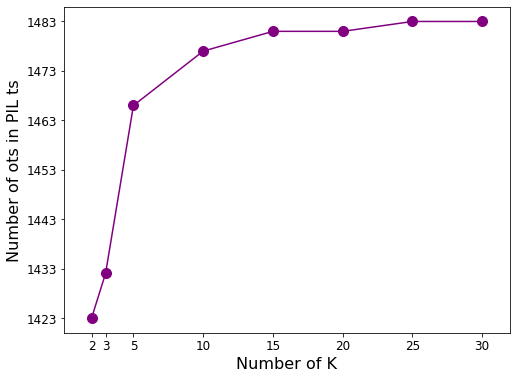

In [354]:
import matplotlib.transforms as mtransforms


K_cluster = np.array([2,3,5,10,15,20,25,30])
out_trj = np.array([1423,1432,1466,1477,1481,1481,1483,1483])

fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

trans_offset = mtransforms.offset_copy(ax.transData, fig=fig,x=-0.25, y=0.20, units='inches')


# for x, y in zip(K_cluster, out_trj):
# #     plt.plot(x, y, 'ro-')
#     plt.text(x, y, '%d' % (int(y)), transform=trans_offset,fontsize = 12)
    

plt.xticks(K_cluster,fontsize = 12)
plt.yticks(np.arange(int(min(out_trj)), int(max(out_trj)+10), 10),fontsize = 12)
plt.xlim(0,32)
# plt.ylim(1400,1490)
plt.plot(K_cluster, out_trj, 'o-',markersize = 10,color = 'purple')
plt.xlabel('Number of K',fontsize = 16)
plt.ylabel('Number of ots in PIL ts',fontsize = 16)
# plt.title('Silhouette_score For Optimal k')
plt.savefig('PIL_01_2000_K_ots_update.png',bbox_inches='tight')
plt.show()